In [1]:
import xarray as xr
import numpy as np
from datetime import datetime as dt
from matplotlib import pyplot as plt
import cmweather
from glob import glob

In [2]:
date_i_want = dt(2022, 6, 2, 0, 0, 0)

In [3]:
tfm = xr.open_dataset(f'/Volumes/LtgSSD/tobac_saves/tobac_Save_{date_i_want.strftime("%Y%m%d")}/seabreeze-obs.zarr')

/Users/stgardner4/micromamba/envs/tracer/lib/python3.12/site-packages/zarr/codecs/vlen_utf8.py:44: UserWarning: The codec `vlen-utf8` is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  return cls(**configuration_parsed)
/var/folders/sp/1j_lh9313dg42jrzhsfb4mk40000gn/T/ipykernel_5264/304883932.py:1: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  tfm = xr.open_dataset(f'/Volumes/LtgSSD/tobac_saves/tobac_Save_{date_i_want.strftime("%Y%m%d")}/seabreeze-obs.zarr')


In [4]:
feature_i_want = 15943
meltlayer = 4500

In [5]:
tfm_feat_time = tfm.sel(feature=feature_i_want)
this_feat_time_idx = tfm_feat_time.feature_time_index.data.item()
tfm_feat_time = tfm_feat_time.isel(time=this_feat_time_idx)
if this_feat_time_idx == 0:
    print('Fallback')
    previous_time = tfm.time.data[this_feat_time_idx + 1]
else:
    previous_time = tfm.time.data[this_feat_time_idx - 1]

In [6]:
this_time = tfm_feat_time.time.data
radar_time = this_time.astype('datetime64[s]').astype(dt).item()

In [7]:
print(previous_time, this_time)

2022-06-02T23:14:17.391000064 2022-06-02T23:19:09.356000000


In [8]:
radar_filepath = f'/Volumes/LtgSSD/nexrad_gridded/{radar_time.strftime("%B").upper()}/{radar_time.strftime("%Y%m%d")}/KHGX{radar_time.strftime("%Y%m%d_%H%M%S")}_V06_grid.nc'

In [9]:
radar_ds = xr.open_dataset(radar_filepath).isel(time=0)

In [10]:
date_i_want.strftime("%m")

'06'

In [11]:
lightning_filepaths = glob(f'/Volumes/LtgSSD/{int(date_i_want.strftime("%m"))}/6sensor_minimum/LYLOUT_{date_i_want.strftime("%y%m%d")}*.nc')
if len(lightning_filepaths) != 1:
    raise ValueError('Expected exactly one lightning data file, but found:', len(lightning_filepaths))
lightning_filepath = lightning_filepaths[0]
lightning = xr.open_dataset(lightning_filepath)
lightning_data_at_time = lightning.sel(grid_time=slice(previous_time, this_time))

/var/folders/sp/1j_lh9313dg42jrzhsfb4mk40000gn/T/ipykernel_5264/1658070707.py:5: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  lightning = xr.open_dataset(lightning_filepath)
/var/folders/sp/1j_lh9313dg42jrzhsfb4mk40000gn/T/ipykernel_5264/1658070707.py:5: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  lightning = xr.open_dataset(lightning_filepath)


In [12]:
flash_mask = (lightning_data_at_time.flash_time_start.data > previous_time) & (lightning_data_at_time.flash_time_end.data < this_time)
event_mask = (lightning_data_at_time.event_time.data > previous_time) & (lightning_data_at_time.event_time.data < this_time)
lightning_data_at_time = lightning_data_at_time.isel(number_of_flashes=flash_mask, number_of_events=event_mask)

In [13]:
feature_segm_mask = tfm_feat_time.segmentation_mask == feature_i_want
feature_composite_refl = radar_ds.reflectivity.max(dim='z').data
feature_composite_refl[~feature_segm_mask] = np.nan

In [14]:
x2d, y2d = np.meshgrid(radar_ds.x.values, radar_ds.y.values)

In [15]:
ys_of_feature = tfm_feat_time.y.data * feature_segm_mask.max(dim='x')
ys_of_feature[~feature_segm_mask.max(dim='x')] = np.nan
feature_min_y = ys_of_feature.min().item()
feature_max_y = ys_of_feature.max().item()

xs_of_feature = tfm_feat_time.x.data * feature_segm_mask.max(dim='y')
xs_of_feature[~feature_segm_mask.max(dim='y')] = np.nan
feature_min_x = xs_of_feature.min().item()
feature_max_x = xs_of_feature.max().item()

In [16]:
closest_to_melt_layer = np.argmin(np.abs(radar_ds.z.data - meltlayer))
above_melt_layer = radar_ds.isel(z=slice(closest_to_melt_layer, None))
above_melt_layer_zdr_thresholded = ((above_melt_layer.differential_reflectivity > 1.0) & (above_melt_layer.reflectivity > 10)).sum(dim='z').data.astype(float)
above_melt_layer_zdr_thresholded[above_melt_layer_zdr_thresholded == 0] = np.nan
above_melt_layer_kdp_thresholded = ((above_melt_layer.KDP_CSU > 0.75) & (above_melt_layer.reflectivity > 10)).sum(dim='z').data.astype(float)
above_melt_layer_kdp_thresholded[above_melt_layer_kdp_thresholded == 0] = np.nan

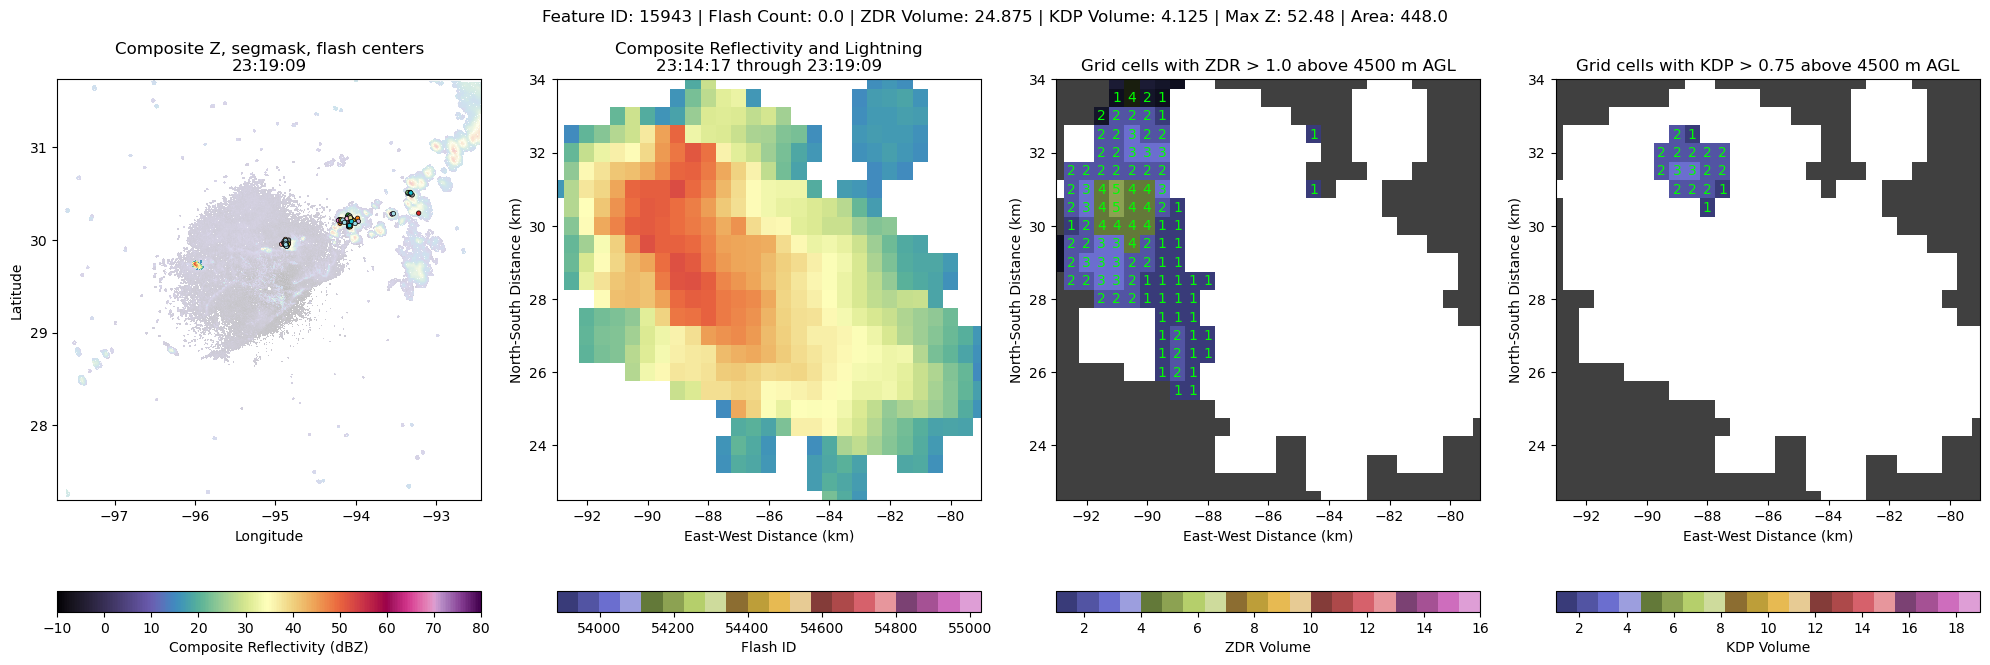

In [17]:
fig, axs = plt.subplots(1, 4, figsize=(20, 7))
feature_segm_mask_trasparent = feature_segm_mask.data.copy().astype(float)
feature_segm_mask_trasparent[feature_segm_mask] = np.nan
reflhandle = axs[0].pcolormesh(tfm.lon, tfm.lat, radar_ds.reflectivity.max(dim='z').data, cmap='ChaseSpectral', vmin=-10, vmax=80)
axs[0].pcolormesh(tfm.lon, tfm.lat, feature_segm_mask_trasparent, cmap='Greys', alpha=0.75)
axs[0].scatter(lightning_data_at_time.flash_center_longitude, lightning_data_at_time.flash_center_latitude, c=lightning_data_at_time.flash_id, cmap='tab20', s=10, linewidths=0.5, edgecolors='black')
axs[0].set_xlabel('Longitude')
axs[0].set_ylabel('Latitude')
axs[0].set_title(f'Composite Z, segmask, flash centers\n{radar_time.strftime("%H:%M:%S")}')
fig.colorbar(reflhandle, ax=axs[0], label='Composite Reflectivity (dBZ)', orientation='horizontal')
axs[1].pcolormesh(x2d/1000, y2d/1000, feature_composite_refl, cmap='ChaseSpectral', vmin=-10, vmax=80)
axs[1].set_xlim(feature_min_x/1000, feature_max_x/1000)
axs[1].set_ylim(feature_min_y/1000, feature_max_y/1000)
flash_handle = axs[1].scatter(lightning_data_at_time.event_x/1000, lightning_data_at_time.event_y/1000, c=lightning_data_at_time.event_parent_flash_id, cmap='tab20b', s=3, linewidths=0.5, edgecolors='black')
axs[1].scatter(lightning_data_at_time.flash_ctr_x/1000, lightning_data_at_time.flash_ctr_y/1000, c=lightning_data_at_time.flash_id, cmap='tab20b', marker='*', s=50, linewidths=1, edgecolors='black')
axs[1].scatter(lightning_data_at_time.flash_init_x/1000, lightning_data_at_time.flash_init_y/1000, c=lightning_data_at_time.flash_id, cmap='tab20b', marker='^', s=50, linewidths=1, edgecolors='black')
axs[1].set_xlabel('East-West Distance (km)')
axs[1].set_ylabel('North-South Distance (km)')
axs[1].set_title(f'Composite Reflectivity and Lightning\n{previous_time.astype("datetime64[s]").astype(dt).strftime("%H:%M:%S")} through {radar_time.strftime("%H:%M:%S")}')
fig.colorbar(flash_handle, ax=axs[1], label='Flash ID', orientation='horizontal')
zdr_handle = axs[2].pcolormesh(radar_ds.x/1000, radar_ds.y/1000, above_melt_layer_zdr_thresholded, cmap='tab20b')
axs[2].pcolormesh(tfm.x/1000, tfm.y/1000, feature_segm_mask_trasparent, cmap='Greys_r', alpha=0.75)
axs[2].set_xlim(feature_min_x/1000, feature_max_x/1000)
axs[2].set_ylim(feature_min_y/1000, feature_max_y/1000)
axs[2].set_xlabel('East-West Distance (km)')
axs[2].set_ylabel('North-South Distance (km)')
axs[2].set_title(f'Grid cells with ZDR > 1.0 above {meltlayer} m AGL')
fig.colorbar(zdr_handle, ax=axs[2], label='ZDR Volume', orientation='horizontal')
for i, val in enumerate(above_melt_layer_zdr_thresholded.flatten()):
    if np.isnan(val):
        continue
    x_coord = x2d.flatten()[i]/1000
    y_coord = y2d.flatten()[i]/1000
    if x_coord > feature_min_x/1000 and x_coord < feature_max_x/1000 and y_coord > feature_min_y/1000 and y_coord < feature_max_y/1000:
            axs[2].text(x_coord, y_coord, f'{val:.0f}', ha='center', va='center', transform=axs[2].transData, color='lime')
kdp_handle = axs[3].pcolormesh(radar_ds.x/1000, radar_ds.y/1000, above_melt_layer_kdp_thresholded, cmap='tab20b')
axs[3].pcolormesh(tfm.x/1000, tfm.y/1000, feature_segm_mask_trasparent, cmap='Greys_r', alpha=0.75)
axs[3].set_xlim(feature_min_x/1000, feature_max_x/1000)
axs[3].set_ylim(feature_min_y/1000, feature_max_y/1000)
axs[3].set_xlabel('East-West Distance (km)')
axs[3].set_ylabel('North-South Distance (km)')
axs[3].set_title(f'Grid cells with KDP > 0.75 above {meltlayer} m AGL')
for i, val in enumerate(above_melt_layer_kdp_thresholded.flatten()):
    if np.isnan(val):
        continue
    x_coord = x2d.flatten()[i]/1000
    y_coord = y2d.flatten()[i]/1000
    if x_coord > feature_min_x/1000 and x_coord < feature_max_x/1000 and y_coord > feature_min_y/1000 and y_coord < feature_max_y/1000:
            axs[3].text(x_coord, y_coord, f'{val:.0f}', ha='center', va='center', transform=axs[3].transData, color='lime')
fig.colorbar(kdp_handle, ax=axs[3], label='KDP Volume', orientation='horizontal')
fig.suptitle(f'Feature ID: {feature_i_want} | Flash Count: {tfm_feat_time.feature_flash_count.data.item():.1f} | ZDR Volume: {tfm_feat_time.feature_zdrvol.data.item()} | KDP Volume: {tfm_feat_time.feature_kdpvol.data.item()} | Max Z: {tfm_feat_time.feature_maxrefl.data.item():.2f} | Area: {tfm_feat_time.feature_area.data.item()}')
fig.tight_layout()

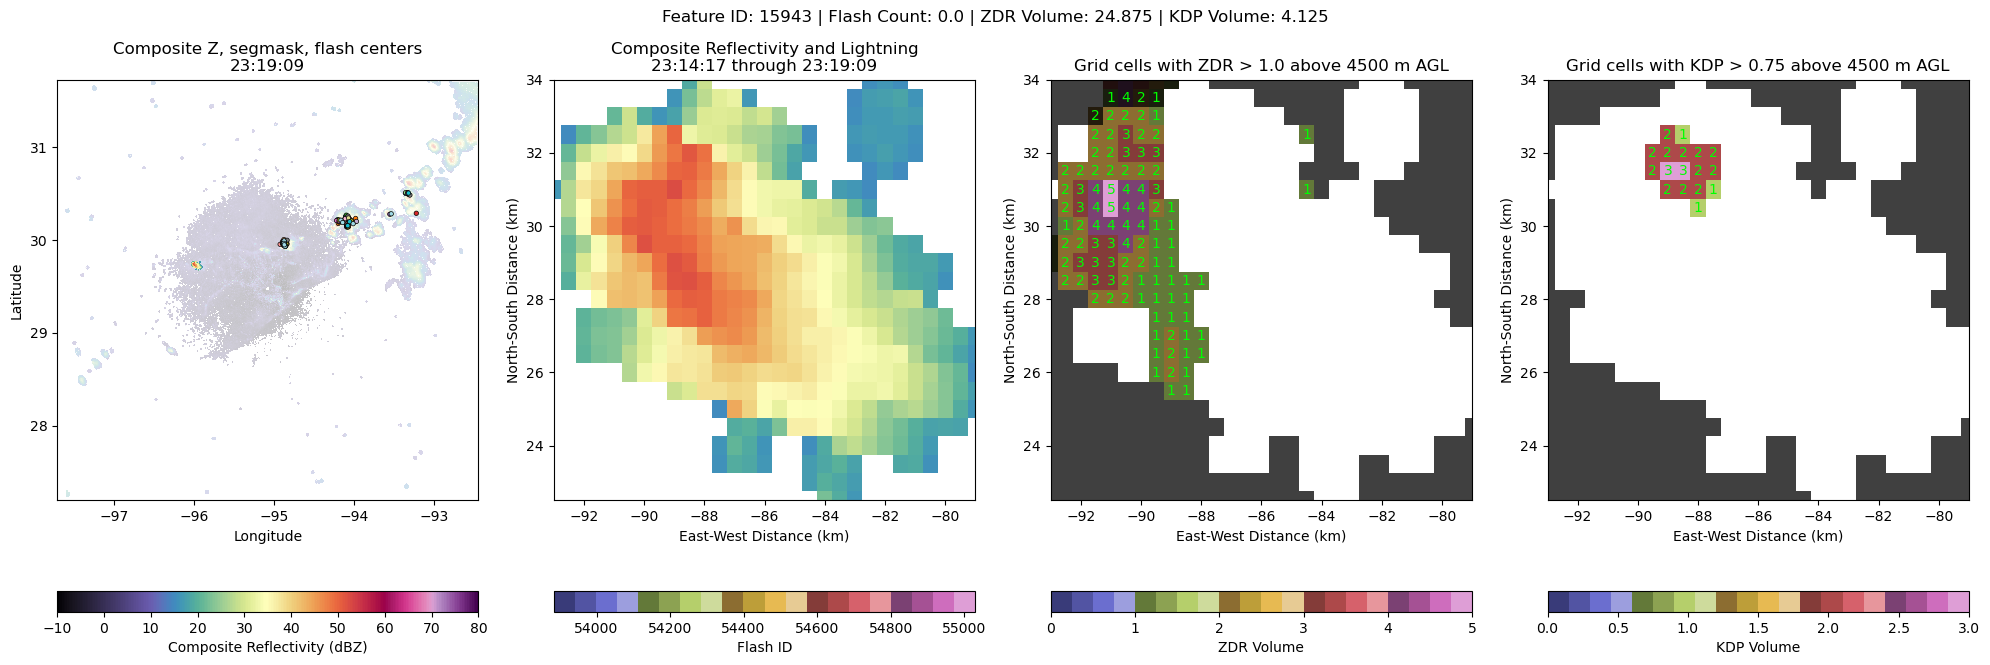

In [18]:
if tfm_feat_time.feature_area == 0:
    feature_min_x = tfm_feat_time.feature_projection_x_coordinate.data.item()-1000
    feature_max_x = tfm_feat_time.feature_projection_x_coordinate.data.item()+1000
    feature_min_y = tfm_feat_time.feature_projection_y_coordinate.data.item()-1000
    feature_max_y = tfm_feat_time.feature_projection_y_coordinate.data.item()+1000
    zdr_thresh_vmax = 0
    kdp_thresh_vmax = 0
else:
    zdr_thresh_vmax = np.nanmax(above_melt_layer_zdr_thresholded[feature_segm_mask])
    if zdr_thresh_vmax == 0:
        zdr_thresh_vmax = 1
    kdp_thresh_vmax = np.nanmax(above_melt_layer_kdp_thresholded[feature_segm_mask])
    if kdp_thresh_vmax == 0:
        kdp_thresh_vmax = 1

fig, axs = plt.subplots(1, 4, figsize=(20, 7))
feature_segm_mask_trasparent = feature_segm_mask.data.copy().astype(float)
feature_segm_mask_trasparent[feature_segm_mask] = np.nan
reflhandle = axs[0].pcolormesh(tfm.lon, tfm.lat, radar_ds.reflectivity.max(dim='z').data, cmap='ChaseSpectral', vmin=-10, vmax=80)
axs[0].pcolormesh(tfm.lon, tfm.lat, feature_segm_mask_trasparent, cmap='Greys', alpha=0.75)
axs[0].scatter(lightning_data_at_time.flash_center_longitude, lightning_data_at_time.flash_center_latitude, c=lightning_data_at_time.flash_id, cmap='tab20', s=10, linewidths=0.5, edgecolors='black')
axs[0].set_xlabel('Longitude')
axs[0].set_ylabel('Latitude')
axs[0].set_title(f'Composite Z, segmask, flash centers\n{radar_time.strftime("%H:%M:%S")}')
fig.colorbar(reflhandle, ax=axs[0], label='Composite Reflectivity (dBZ)', orientation='horizontal')
axs[1].pcolormesh(x2d/1000, y2d/1000, feature_composite_refl, cmap='ChaseSpectral', vmin=-10, vmax=80)
axs[1].set_xlim(feature_min_x/1000, feature_max_x/1000)
axs[1].set_ylim(feature_min_y/1000, feature_max_y/1000)
flash_handle = axs[1].scatter(lightning_data_at_time.event_x/1000, lightning_data_at_time.event_y/1000, c=lightning_data_at_time.event_parent_flash_id, cmap='tab20b', s=3, linewidths=0.5, edgecolors='black')
axs[1].scatter(lightning_data_at_time.flash_ctr_x/1000, lightning_data_at_time.flash_ctr_y/1000, c=lightning_data_at_time.flash_id, cmap='tab20b', marker='*', s=50, linewidths=1, edgecolors='black')
axs[1].scatter(lightning_data_at_time.flash_init_x/1000, lightning_data_at_time.flash_init_y/1000, c=lightning_data_at_time.flash_id, cmap='tab20b', marker='^', s=50, linewidths=1, edgecolors='black')
axs[1].set_xlabel('East-West Distance (km)')
axs[1].set_ylabel('North-South Distance (km)')
axs[1].set_title(f'Composite Reflectivity and Lightning\n{previous_time.astype("datetime64[s]").astype(dt).strftime("%H:%M:%S")} through {radar_time.strftime("%H:%M:%S")}')
fig.colorbar(flash_handle, ax=axs[1], label='Flash ID', orientation='horizontal')
zdr_handle = axs[2].pcolormesh(radar_ds.x/1000, radar_ds.y/1000, above_melt_layer_zdr_thresholded, cmap='tab20b', vmin=0, vmax=zdr_thresh_vmax)
axs[2].pcolormesh(tfm.x/1000, tfm.y/1000, feature_segm_mask_trasparent, cmap='Greys_r', alpha=0.75)
axs[2].set_xlim(feature_min_x/1000, feature_max_x/1000)
axs[2].set_ylim(feature_min_y/1000, feature_max_y/1000)
axs[2].set_xlabel('East-West Distance (km)')
axs[2].set_ylabel('North-South Distance (km)')
axs[2].set_title(f'Grid cells with ZDR > 1.0 above {meltlayer} m AGL')
fig.colorbar(zdr_handle, ax=axs[2], label='ZDR Volume', orientation='horizontal')
for i, val in enumerate(above_melt_layer_zdr_thresholded.flatten()):
    if np.isnan(val):
        continue
    x_coord = x2d.flatten()[i]/1000
    y_coord = y2d.flatten()[i]/1000
    if x_coord > feature_min_x/1000 and x_coord < feature_max_x/1000 and y_coord > feature_min_y/1000 and y_coord < feature_max_y/1000:
            axs[2].text(x_coord, y_coord, f'{val:.0f}', ha='center', va='center', transform=axs[2].transData, color='lime')
kdp_handle = axs[3].pcolormesh(radar_ds.x/1000, radar_ds.y/1000, above_melt_layer_kdp_thresholded, cmap='tab20b', vmin=0, vmax=kdp_thresh_vmax)
axs[3].pcolormesh(tfm.x/1000, tfm.y/1000, feature_segm_mask_trasparent, cmap='Greys_r', alpha=0.75)
axs[3].set_xlim(feature_min_x/1000, feature_max_x/1000)
axs[3].set_ylim(feature_min_y/1000, feature_max_y/1000)
axs[3].set_xlabel('East-West Distance (km)')
axs[3].set_ylabel('North-South Distance (km)')
axs[3].set_title(f'Grid cells with KDP > 0.75 above {meltlayer} m AGL')
for i, val in enumerate(above_melt_layer_kdp_thresholded.flatten()):
    if np.isnan(val):
        continue
    x_coord = x2d.flatten()[i]/1000
    y_coord = y2d.flatten()[i]/1000
    if x_coord > feature_min_x/1000 and x_coord < feature_max_x/1000 and y_coord > feature_min_y/1000 and y_coord < feature_max_y/1000:
            axs[3].text(x_coord, y_coord, f'{val:.0f}', ha='center', va='center', transform=axs[3].transData, color='lime')
fig.colorbar(kdp_handle, ax=axs[3], label='KDP Volume', orientation='horizontal')
fig.suptitle(f'Feature ID: {feature_i_want} | Flash Count: {tfm_feat_time.feature_flash_count.data.item():.1f} | ZDR Volume: {tfm_feat_time.feature_zdrvol.data.item()} | KDP Volume: {tfm_feat_time.feature_kdpvol.data.item()}')
fig.tight_layout()